In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(old_train_data,old_test_data,train_to_date):
    new_train = pd.concat([old_train_data,old_test_data[old_test_data.index<=train_to_date]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False)
    new_test = old_test_data[~old_test_data.index.isin(new_train['calculation_date'])].copy().reset_index(drop=False)
    arrs = trainer.get_train_test_arrays(new_train, new_test)
    train_X = arrs['train_X']
    train_y = arrs['train_y']
    test_X = arrs['test_X']
    test_y = arrs['test_y']
    preprocessor = trainer.preprocess()
    retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
    train_test = trainer.test_prediction_accuracy(new_train,new_test,retrained_model)
    new_test_data = train_test['test_data'].set_index('calculation_date')
    new_train_data = train_test['train_data'].set_index('calculation_date')
    print()
    plot_errors(plotcols,new_test_data,new_train_data)
    return new_train_data, new_test_data

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('.')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 180435470848 short-term cboe asians
1     2024_11_01 195924619203 live cboe barriers
2     2024_11_01 204910611379 bloomberg barriers
3     2024_11_01 205356527985 bloomberg asians


# loading data

0     2024_11_01 180435470848 short-term cboe asians test_data.csv
1     2024_11_01 180435470848 short-term cboe asians train_data.csv
2     2024_11_01 180435470848 short-term cboe asians.pkl

spot price 
0      5177.00
1      5178.50
2      5178.75
3      5179.00
4      5189.00
        ...   
841    5864.25
842    5864.50
843    5865.00
844    5865.50
845    5866.50
Name: spot_price, Length: 846, dtype: float64

strike price 
0       2588.0
1       2589.0
2       2594.0
3       2595.0
4       2599.0
         ...  
2256    8795.0
2257    8796.0
2258    8797.0
2259    8798.0
2260    8799.0
Name: strike_price, Length: 2261, dtype: float64

days to maturity 
0     7
1    28
2    84
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0    0.0
Name: dividend_rate, dtype: float64

kappa 
0         0.000824
1         0.002276
2         0.003055
3         0.003275
4         0.006201
           ...    
1090    139.256572
1091    1

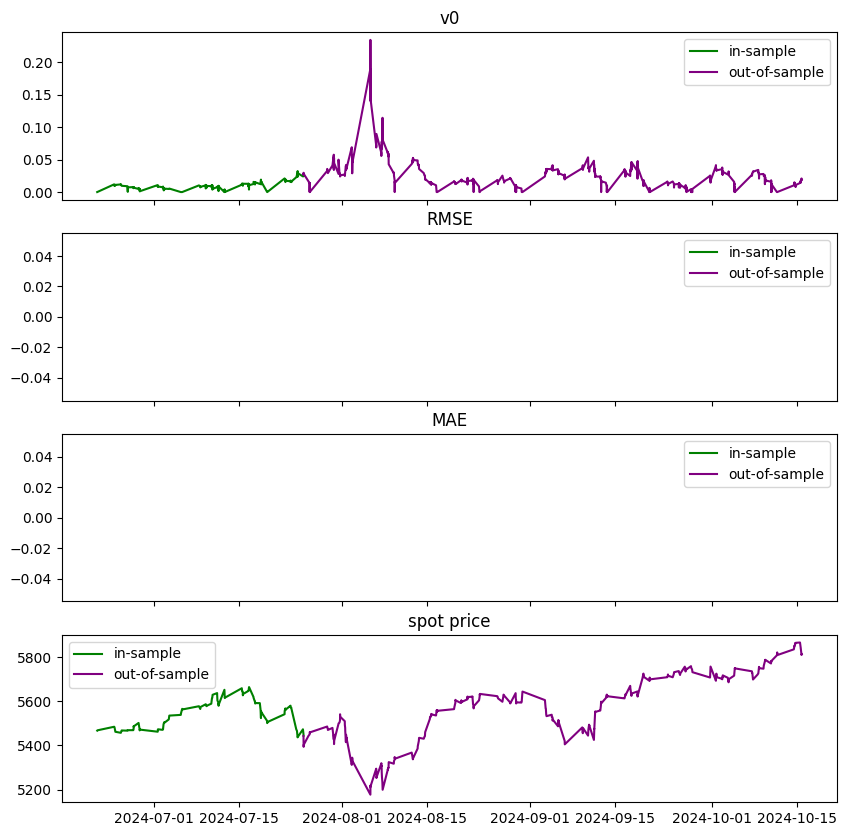

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,rho,eta,v0,asian,observed_price,outofsample_target,outofsample_prediction,outofsample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2024-10-15 16:50:04.131,5813.50,2906.00,7,1.0,7,0,arithmetic,call,0.04,0.0,...,-0.657095,1.705566,0.018946,2907.984007,2907.957053,2907.957053,2902.457548,-5.499504,NaN,NaN
2024-10-15 16:50:04.131,5813.50,7266.50,28,1.0,28,0,arithmetic,put,0.04,0.0,...,-0.657095,1.705566,0.018946,1439.527901,1439.564186,1439.564186,1452.361482,12.797296,NaN,NaN
2024-10-15 16:50:04.131,5813.50,8720.00,84,12.0,7,0,arithmetic,call,0.04,0.0,...,-0.657095,1.705566,0.018946,0.000000,0.028330,0.028330,31.970585,31.942255,NaN,NaN
2024-10-15 16:50:04.131,5813.50,8720.00,84,12.0,7,0,geometric,put,0.04,0.0,...,-0.657095,1.705566,0.018946,2851.847170,2851.895845,2851.895845,2795.910499,-55.985346,NaN,NaN
2024-10-15 16:50:04.131,5813.50,7266.50,84,12.0,7,0,arithmetic,put,0.04,0.0,...,-0.657095,1.705566,0.018946,1408.259569,1408.284228,1408.284228,1437.757857,29.473629,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25 15:35:00.352,5442.75,8164.00,84,3.0,28,0,geometric,put,0.04,0.0,...,-0.575800,2.047027,0.027143,2674.680548,2674.672595,2674.672595,2675.742381,1.069786,NaN,NaN
2024-07-25 15:35:00.352,5442.75,8164.00,84,3.0,28,0,geometric,call,0.04,0.0,...,-0.575800,2.047027,0.027143,0.000000,0.017847,0.017847,11.083360,11.065513,NaN,NaN
2024-07-25 15:35:00.352,5442.75,6803.25,84,3.0,28,0,arithmetic,call,0.04,0.0,...,-0.575800,2.047027,0.027143,0.018240,0.015194,0.015194,4.753050,4.737856,NaN,NaN


In [4]:
"""
select model here
"""
model = models[0]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
print()
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('train')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('test')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
test_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)
test_data

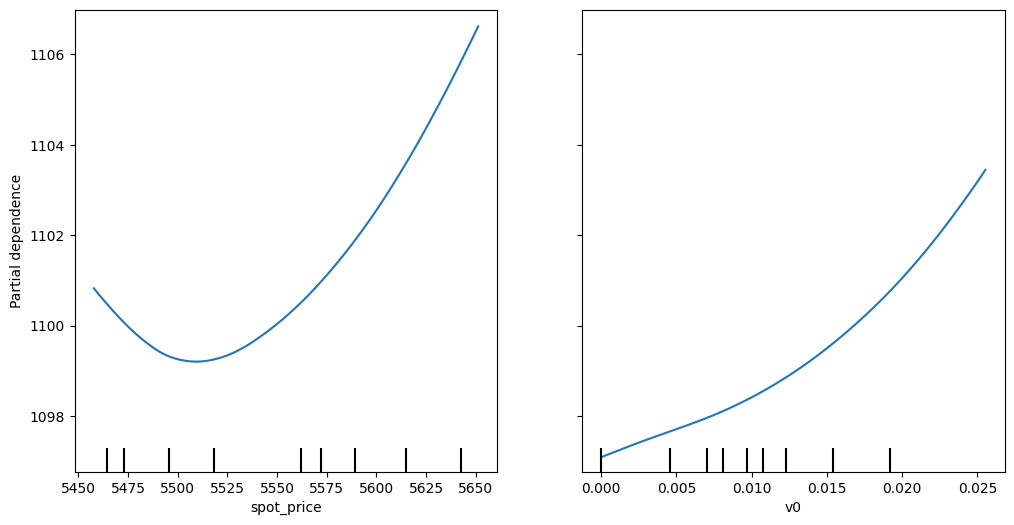

In [5]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, ['spot_price','v0'], ax=ax)

# retraining

In [6]:
retraining_frequency = 20
retraining_i = np.arange(retraining_frequency,len(test_dates),retraining_frequency)
retraining_dates = test_dates[retraining_i].reset_index(drop=True)
print(retraining_dates)

0    2024-07-26 15:59:31.246
1    2024-07-29 15:53:08.349
2    2024-07-30 16:41:35.052
3    2024-07-31 16:25:17.602
4    2024-08-01 16:58:50.449
5    2024-08-05 15:57:41.780
6    2024-08-06 14:59:12.541
7    2024-08-07 11:12:11.596
8    2024-08-08 13:02:05.979
9    2024-08-09 12:30:13.692
10   2024-08-12 11:14:42.983
11   2024-08-13 10:39:14.146
12   2024-08-14 10:51:56.044
13   2024-08-15 10:59:49.774
14   2024-08-16 11:25:46.266
15   2024-08-19 10:35:51.491
16   2024-08-20 14:01:40.351
17   2024-08-21 15:43:56.669
18   2024-08-22 11:08:05.642
19   2024-08-23 15:03:07.780
20   2024-08-26 16:00:05.238
21   2024-08-28 16:41:08.643
22   2024-08-29 16:00:06.009
23   2024-09-03 09:47:35.339
24   2024-09-04 12:38:34.200
25   2024-09-05 13:30:23.456
26   2024-09-06 15:50:07.195
27   2024-09-09 15:26:08.133
28   2024-09-10 13:31:43.943
29   2024-09-11 11:57:44.238
30   2024-09-12 12:41:35.129
31   2024-09-13 14:21:01.728
32   2024-09-16 12:48:58.819
33   2024-09-17 11:16:50.534
34   2024-09-1


Fri Jul 26 15:59:31 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 8.8828125

in sample:
     RMSE: 6.427063324795035
     MAE: 3.6661427457159546

out of sample:
     RMSE: 68.96532409480093
     MAE: 15.30208160874255



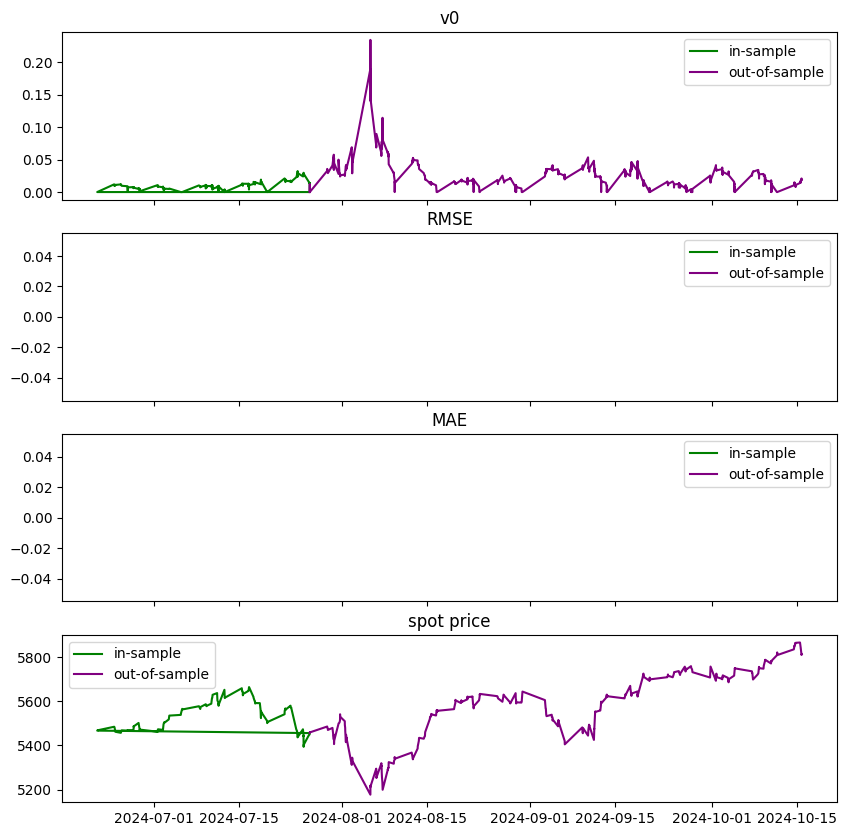



Mon Jul 29 15:53:08 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 9.352634906768799

in sample:
     RMSE: 6.752361683906178
     MAE: 4.621823194593762

out of sample:
     RMSE: 28.663685744812017
     MAE: 11.39163902110826



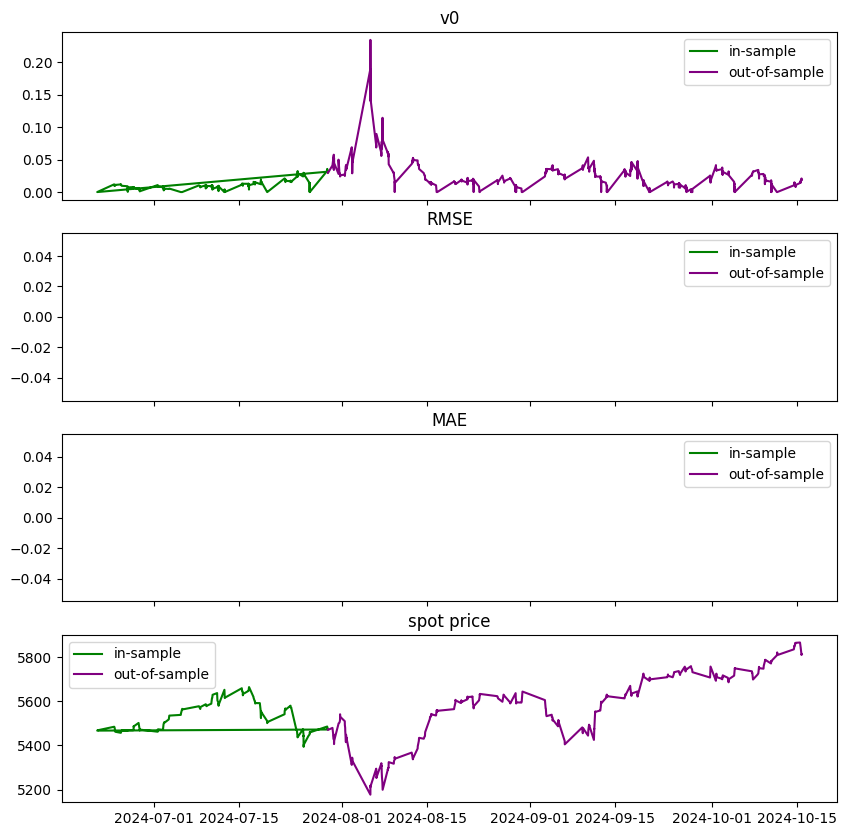



Tue Jul 30 16:41:35 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 9.326894521713257

in sample:
     RMSE: 6.680781890078771
     MAE: 3.9710078824995265

out of sample:
     RMSE: 29.115937777881623
     MAE: 14.126839182417635



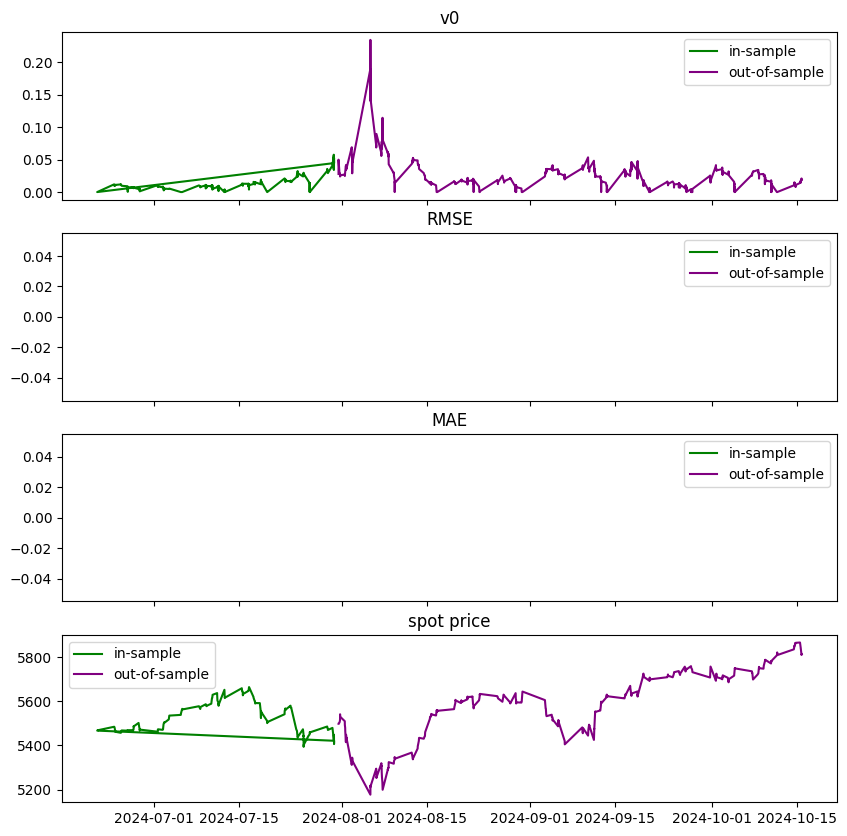



Wed Jul 31 16:25:17 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 10.121840000152588

in sample:
     RMSE: 6.6428756175102235
     MAE: 4.261849658163364

out of sample:
     RMSE: 28.59724248049236
     MAE: 14.47120765680062



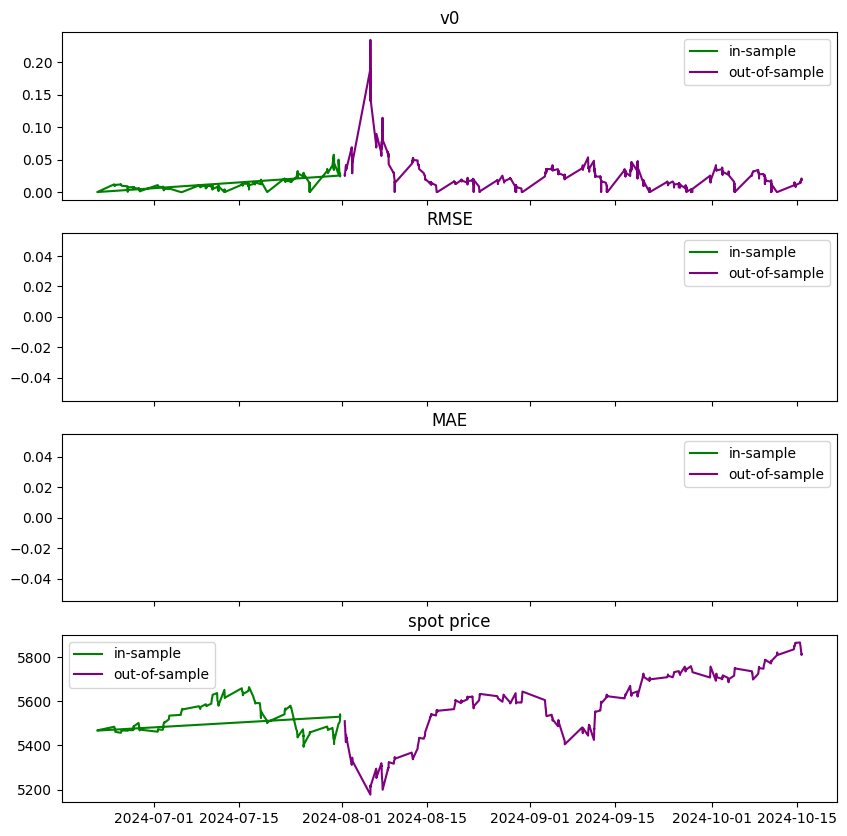



Thu Aug  1 16:58:50 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 10.765511989593506

in sample:
     RMSE: 6.063324417671977
     MAE: 4.0483711513499605

out of sample:
     RMSE: 14.287714284683648
     MAE: 8.318849112251552



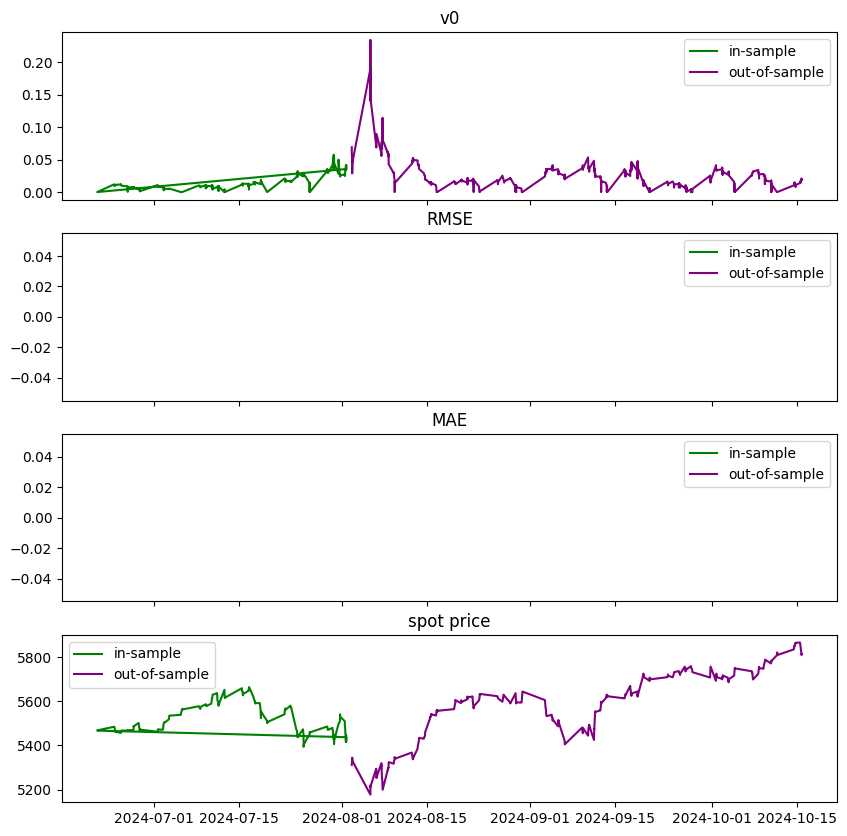



Mon Aug  5 15:57:41 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 11.08439326286316

in sample:
     RMSE: 5.20510264344204
     MAE: 3.3265196233765897

out of sample:
     RMSE: 12.83189188682124
     MAE: 7.138608495679269



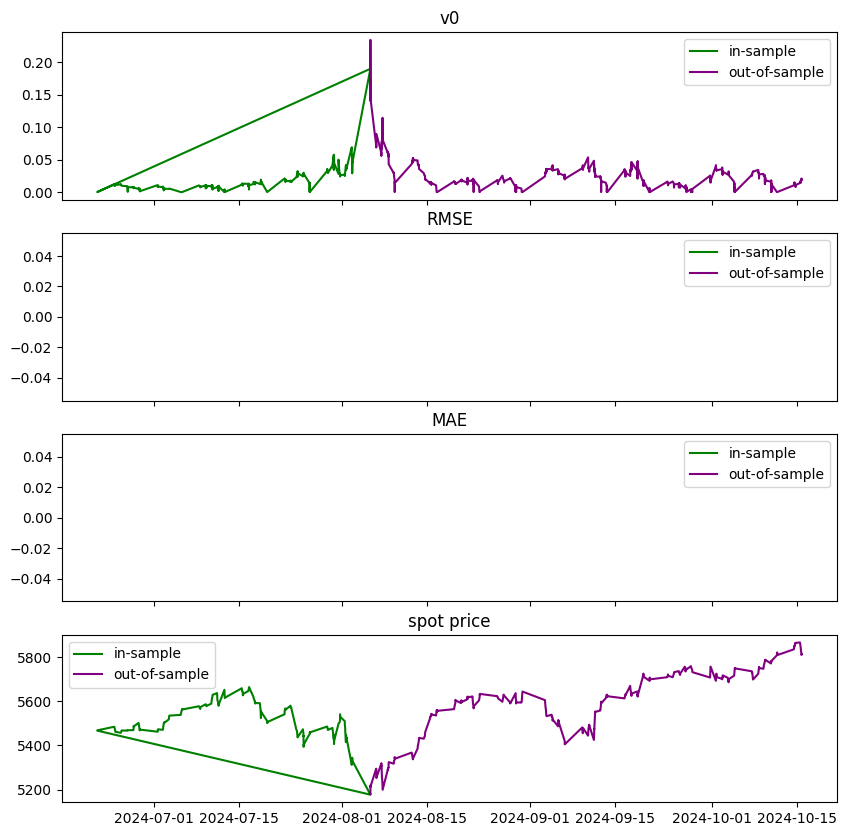



Tue Aug  6 14:59:12 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 11.361308574676514

in sample:
     RMSE: 7.5819951431269885
     MAE: 4.858859287327306

out of sample:
     RMSE: 12.476386228433995
     MAE: 7.982440536802102



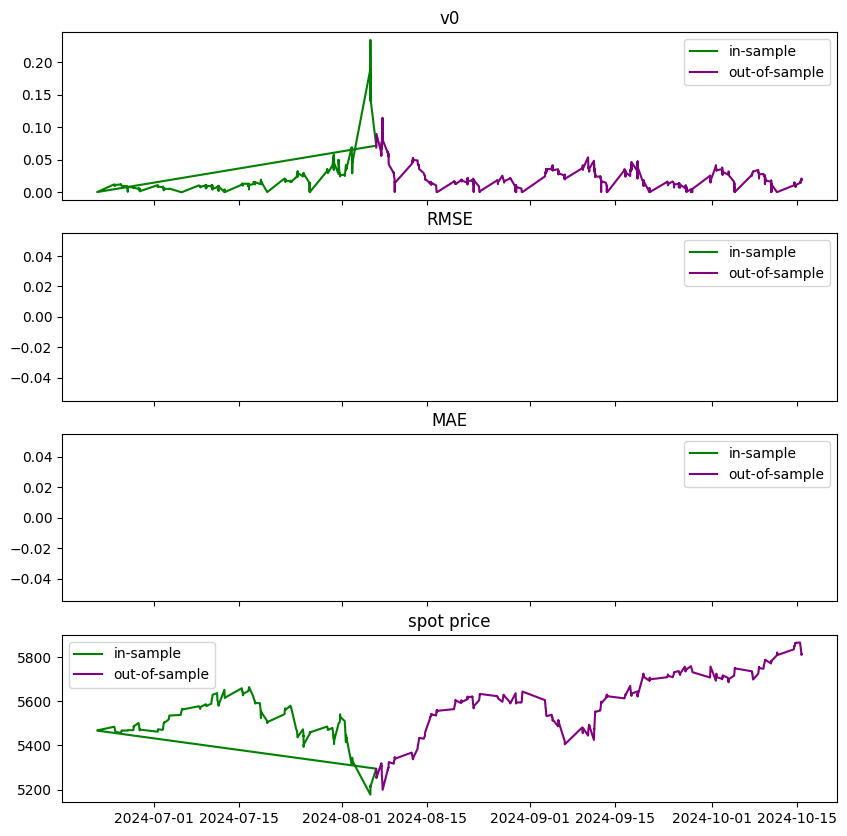



Wed Aug  7 11:12:11 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 11.97773551940918

in sample:
     RMSE: 6.734545677245858
     MAE: 4.405247539204372

out of sample:
     RMSE: 12.547324239211479
     MAE: 8.12234113635524



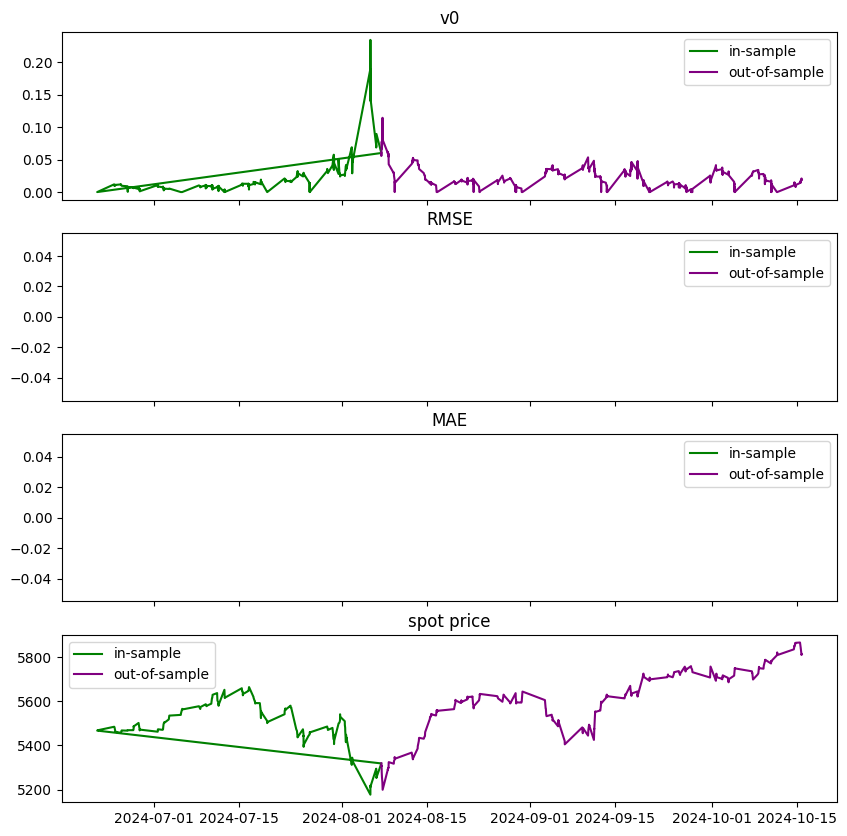



Thu Aug  8 13:02:05 2024

training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001


In [ ]:
for date in retraining_dates:
    print()
    print(date.strftime('%c'))
    retrain(train_data,test_data,date)
    print()